In [1]:
import pandas as pd
import xlrd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import datetime
import math
sns.set()
mesta = ["NS_CE","ZR_SU","KI_KI","NS_NE","RU_IK"]
sorte = ["ZD","AJ"]

%matplotlib notebook

In [25]:
###Citanje tabela sa PIS sajta
### Tabele su prethodno prebacene u xls format
###
#*Vadjenje pouzdanih periods
#*Nalazenje i zabalezavanje rupa u temperaturama i u datumima (satima)


folder_podataka = "./PISpodaci"
folder_rezultata = "./results"
pregled = pd.read_excel("./samoPouzdaniPodaciTabela.xlsx", converters= {'kraj': pd.to_datetime, 'pocetak': pd.to_datetime})
preslikavanje_opstina = {"Novi Sad": "NS", "Ruma":"RU","Sombor":"SO","Zrenjanin":"ZR","Kikinda":"KI"}
preslikavanje_lokacija = {"Cenej": "CE" ,"Novi Slankamen":"NS","Ridjica":"RI","Sremski Karlovci":"SK","Sutjeska":"SU","Kikinda":"KI","Nestin":"NE","Irig-Kudos":"IK"}
z=None
#za svaku PIS tabelu, cemo napraviti korespondirajucu PIS tabelu, sa pouzdanim podacima + vrsta i mesto
# VAZNO !! Moraju biti prebaceni u xls format posle skidanja sa PIS sajta. To se moze uraditi otvaranjem u Excelu i cuvsanju u xls formatu
for fname in os.listdir(folder_podataka):
    print (fname)
    #IZVLACENJE AMS naziva iz imena fajla !
    ams =fname.split('_')[0] ## REFACTOR - ovo mora da bude regex. 
    print(ams)
    assert(re.match("0+[0-9A-F]+",ams)) # REFACTOR - napravi bolji regex, more robust
    #IZVLACENJE PODATAKA IZ PREGLED TABELE
    record_for_ams = pregled[pregled.ams==ams] #za ovu ams samo trzimo records
    #ako nije oznacen kraj - popunimo ga sa trenutnim datumom, posto to znaci da je jos uvek tamo
    record_for_ams.kraj = record_for_ams.kraj.fillna(pd.Timestamp.today())#REFACTOR TODO!! - popuni ih sa poslednjom skinutom vrednoscu za taj AMS (to je preciznije)
    #UCITAVANJE TABELE
    PIStabela=pd.read_excel(os.path.join(folder_podataka,fname),header=[0,1])
    PIStabela = PIStabela.sort_index()
    #flattening the header
    #SREDJIVANJE TABELE!!
    PIStabela.columns = [' '.join(col).strip() for col in PIStabela.columns.values]
    #samo uzimamo temperature, tj prve tri kolone, za ovu svrhu 
    PIStabela = PIStabela.iloc[:,0:3]
    assert("Temperature" in col for col in PIStabela.columns)
#z = pd.concat(z.values(),axis=0)
    assert(len(PIStabela.columns)==3)
    #prvo cemo ih iseci po periodima, i onda cemo ih spojiti u jednu tabelu !!
    tabele_za_jedan_ams = []
    #pravimo i tabele sa nedostajucim vrednostima
    missing_periods_za_jedan_ams = []
    missing_data_za_ams = []
    #idemo kroz PREGLED tabelu i za svaku stavku odvojim deo PIS tabele, koja je pouzdana
    for index,row in record_for_ams.iterrows():
        assert(row.pocetak< row.kraj)
        print (row.pocetak,row.kraj)
        #izuzimamo dan postavljanja, posto ne znamo kad je postavljenja
        izuzet_dan_postavljanja = (row.pocetak+pd.offsets.DateOffset(days=1)) 
        #uzimamo samo deo za koji znamo da je pouzdan (tj. bio na lokaciji bez pomeranja)
        novi = PIStabela.loc[izuzet_dan_postavljanja:row.kraj].copy() 
        #popunjavamo ostale podatke, posto znamo da su bili sigurno na jednoj lokaciji u jednoj sorti za taj period
        novi["opstina"] = row.opstina #popunjavamo podatke, koje sad znamo za sigurno
        novi["mesto"] = row.mesto
        novi["usev"] = row.usev
        tabele_za_jedan_ams.append(novi) #jos uvek smo kod istog AMS-a, i sve sto nadjemo cemo nakaciti
        missing_temperatures = novi[novi.isnull().any(axis=1)] # kolone koje imaju nedostajuce vrednosti, tj. temperature u ovom slucaju
        #cuvamo ovaj deo podataka (mozda je suvisno !)
        novi.to_csv(os.path.join(folder_rezultata,"%s_%s_%s_%s_%s.csv"%(ams,preslikavanje_opstina[row.opstina],preslikavanje_lokacija[row.mesto],row.usev,row.pocetak)))    
        #Trazimo nedostajuce datume 
        idx_ref = pd.DatetimeIndex(start=novi.index[0], end=novi.index[-1], freq="h")
        gaps = idx_ref[~idx_ref.isin(novi.index)]
        missing = pd.DataFrame(index=gaps)
        missing["opstina"]= row.opstina
        missing["mesto"] = row.mesto
        missing["usev"] = row.usev
        #zapisujemo nedostajuce datume za jedan period - mozda suvisno !
        missing.to_csv(os.path.join(folder_rezultata,"missing_periods_%s_%s" %(ams+row.opstina+row.mesto +row.usev,row.pocetak)))
        #sve missinge sa odredjen ams cuvamo u jednoj tabeli - mozemo ih kasnije po lokaciji ako treba
        missing_periods_za_jedan_ams.append(missing)
        missing_data_za_ams.append(missing_temperatures)
    frejmovi_za_ams = pd.concat(tabele_za_jedan_ams)
    
    #svi valjani podaci za jedan ams
    frejmovi_za_ams.to_csv(os.path.join(folder_rezultata,"%s_pouzdaniPeriodi_biljneVrste_lokacije.csv" %(ams)))
    missing_periods = pd.concat(missing_periods_za_jedan_ams)
    missing_periods.to_csv(os.path.join(folder_rezultata,"%s_missing_periods.csv" %ams))
    missing_data = pd.concat(missing_data_za_ams)
    missing_data.to_csv(os.path.join(folder_rezultata,"%s_missing_data.csv" %ams))

00000EA5_station_data.xlsx
00000EA5
2010-04-20 00:00:00 2013-03-29 00:00:00
2013-03-29 00:00:00 2019-01-29 15:24:26.884902
00000DAD_station_data.xlsx
00000DAD
2012-12-03 00:00:00 2019-01-29 15:24:35.516622
00000E94_station_data.xlsx
00000E94
2010-04-16 00:00:00 2019-01-29 15:24:36.704926
00000E8C_station_data.xlsx
00000E8C
2012-01-10 00:00:00 2019-01-29 15:24:45.016397
00000E98_station_data.xlsx
00000E98
2011-02-22 00:00:00 2019-01-29 15:24:45.735596
00000EA1_station_data.xls
00000EA1
2011-07-12 00:00:00 2019-01-29 15:24:47.477182
00000E9A_station_data.xls
00000E9A
2013-08-02 00:00:00 2018-11-19 00:00:00


In [2]:

def izracunaj_CHU(podaci):
    assert(not podaci.empty)

    zbir = 0
    end_of_chilling_index = None
    end_of_chilling_date = None
    chilling_units_max = 1800
    for index, row in podaci.iterrows(): 
        if row.Tavg <= 1.4:
            zbir+=0
        elif row.Tavg <=2.4:
            zbir+=0.5
        elif row.Tavg <= 9.1:
            zbir+=1
        elif row.Tavg <=12.4:
            zbir+=0.5
        elif row.Tavg <=15.9:
            zbir+=0
        elif row.Tavg <=18.0:
            zbir+=-0.5
        else:
            zbir+=-1
    return zbir


def izracunaj_CHU2(podaci):
    zbir=0
    
    for index, row in podaci.iterrows():
        if row.Tavg>0 and row.Tavg<7.2:
            zbir+=1
        else:
            zbir+=0
            
    return zbir

def izracunaj_HU(podaci,Tu=25,GDH_limit = np.inf,f=0.6,make_growth_data = False):
    assert(not podaci.empty)
    
    Tu = Tu # optimum temperature *25 ako nije prosledjen Tu
    Tc = 36 # critical temperature
    Tb = 7.2 #base temperature
    F = 1 # plant stress factor, 1 where no particular stress
    GDH = 0
 #   gdh_growth_graph = pd.DataFrame(columns=["date","GDH"])
    datum_prekidanja = None
    assert( not make_growth_data)
    for i, row in podaci.iterrows():
        #4500 
        if row.Tavg<-0.5:
            F=f
        if GDH>=GDH_limit:
            break
        elif (row.Tavg >=Tb) and (row.Tavg < Tu):
            z =  F*((Tu-Tb)/2)*(1+ math.cos(math.pi + math.pi*((row.Tavg -Tb)/(Tu-Tb))))
            GDH+=z  
        elif (row.Tavg >=Tu) and (row.Tavg<=Tc):
            z= F*(Tu-Tb)*(1+ math.cos(math.pi/2 + (math.pi/2)*((row.Tavg -Tu)/(Tc-Tu))))
            GDH+=z
        else:
            GDH+=0
       # gdh_growth_graph= gdh_growth_graph.append({"date":row.name,"GDH":GDH},ignore_index=True)
        datum_prekidanja = row.name
        
    return GDH,datum_prekidanja
            
#    if make_growth_data:
#        return GDH,datum_prekidanja,gdh_growth_graph
#    else:
    
    
        
def izracunaj_HU_bez_stress(podaci,Tu=25,GDH_limit = 4500):
    
    Tu = Tu # optimum temperature *25 ako nije prosledjen Tu
    Tc = 36 # critical temperature
    Tb = 7.2 #base temperature
    F = 1 # plant stress factor, 1 where no particular stress
    GDH = 0
    gdh_growth_graph = pd.DataFrame(columns=["date","GDH"])
    for i, row in podaci.iterrows():
        #4500 
        if GDH>=GDH_limit:
            return GDH,row.name,gdh_growth_graph
        elif (row.Tavg >=Tb) and (row.Tavg < Tu):
            z =  F*((Tu-Tb)/2)*(1+ math.cos(math.pi + math.pi*((row.Tavg -Tb)/(Tu-Tb))))
            GDH+=z  
        elif (row.Tavg >=Tu) and (row.Tavg<=Tc):
            z= F*(Tu-Tb)*(1+ math.cos(math.pi/2 + (math.pi/2)*((row.Tavg -Tu)/(Tc-Tu))))
            GDH+=z
        else:
            GDH+=0
        gdh_growth_graph= gdh_growth_graph.append({"date":row.name,"GDH":GDH},ignore_index=True)
            
    return GDH,None,gdh_growth_graph

In [8]:
#REFACTORING in progress

sve_zajedno = pd.DataFrame(columns = ["sorta","lokalitet","CHU","HU","chilling start","dormancy end","dormancy end BBCH","flowering start","flowering start BBCH","dormancy_end offset", "flowering_start offset","Tu","F"])
make_growth_data=False
folder_fenologija = "./fenologija"
folder_podataka = "./results/popunjenirezultati"

#za sve podatke koje imamo popunjene/pouzdane
#cemo citati ove podatke fenologije

def ucitaj_podatke(fname_podaci,folder_podataka):
    lokalitet = fname_podaci[:5] #NS_CE npr
    assert (lokalitet in mesta) #provera 
    print ("lokalitet: %s" %lokalitet)
     #ucitavamo podatke
    podaci = pd.read_csv(os.path.join(folder_podataka,fname_podaci),index_col=0)
    #stavljamo da index bude datum, vazno je da je dayfirst=True, posto su tako sacuvani izgleda
    podaci.index = pd.to_datetime(podaci.index,dayfirst=True)
    return podaci,lokalitet

def ucitaj_i_sortiraj_fenologiju(fname_fenologija,folder_fenologija):
    """Ucitava podatke iz fenologije, stavlja datum kao index, i sortira ih po datumu.
    Odredjuje datume za chilling start, kraj dormancije i pocetak cvetanja i vraca ih"""
    
    def odredi_kraj_dormancije(fenologija):
        """Prima tabelu fenologije, odredjuje kad je dormancija prestala"""
        fenologija.sort_index() #sortira po datumu
        assert(fenologija.index.name=="Date")
        #kraj dormancije je prvi red u tabeli za koji je BBCH>=1
        #kraj dormancije je na poslednjoj jedinici !!!!!!!! prvoj trojci
        if 1 in fenologija.BBCH.tolist():
            dormancy_end = fenologija[fenologija.BBCH==1].iloc[-1]
        else:
            dormancy_end = fenologija[fenologija.BBCH>=1].iloc[0]

        return dormancy_end
    
    def odredi_cvetanje(fenologija):
        #cvetanje je prvi red u tabeli za koje je BBCH>=60
        cvetanje = fenologija[fenologija.BBCH>=60].iloc[0]
        return cvetanje
    
    #uzimamo godinu i sortu iz naziva fajla 
    year = int(fname_fenologija.split("_")[3].split(".")[0])
    sorta = fname_fenologija.split("_")[-2]
    print ("sorta: %s" %sorta)
    #ucitavanje i sredjivanje tabele (sortiranje po datumima)
    fenologija = pd.read_excel(os.path.join(folder_fenologija,fname_fenologija))
    fenologija.Date = pd.to_datetime(fenologija.Date,yearfirst=True)
    fenologija = fenologija.set_index(fenologija.Date).drop("Date",1).sort_index()
    #pocinjemo racunanje od Novembra prosle godine
    chilling_start = pd.Timestamp(year=year-1, month=11, day=15, hour=0)
    dormancy_end = odredi_kraj_dormancije(fenologija)
    cvetanje_start = odredi_cvetanje(fenologija)
    # podaci za racunanje CHU-a, od pocetka novembra do kraja dormancije

    
    return fenologija,year,sorta,chilling_start,dormancy_end,cvetanje_start

#def izracunaj_za_razlicite_Tu_i_zakaci_za_df(Tu_lower_limit,Tu_upper_limit,cvetanje_podaci):
#    global sve_zajedno

def poredi_rezultate():
    global sorte
    global mesta
    rezultat = pd.read_csv("rezultat..??.csv")
    print (rezultat)
    print (rezultat.groupby(["F","Tu","flowering_start offset","dormancy_end offset"]).descr())
    print (rezultat.groupby("Tu").descr())
    print (rezultat.groupby("F").descr())
    
    
def prognoza_cvetanje(HU_mean,Tu_opt,F_opt):
    global sorte
    global mesta
    global folder_fenologija
    global folder_podataka
    sve_zajedno_prognoza = pd.DataFrame(columns = ["sorta","lokalitet","CHU","HU","chilling start","dormancy end","dormancy end BBCH","flowering start","flowering start BBCH","dormancy_end offset", "flowering_start offset","Tu","F"])
    make_growth_data=False
    for fname_podaci in os.listdir(folder_podataka): # za svaki set podataka
        podaci,lokalitet = ucitaj_podatke(fname_podaci,folder_podataka)
        #uzimamo sve podatke fenologije za odabrani lokalitet (tj. onaj koji je na redu)
        gen = (fname for fname in os.listdir(folder_fenologija) if (lokalitet in fname) and ("~" not in fname))
        #za svaku fenolosku tabelu za odabran lokalitet
        for fname_fenologija in gen:
            print (fname_fenologija)
            fenologija,year,sorta,chilling_start,dormancy_end,cvetanje_start = ucitaj_i_sortiraj_fenologiju(fname_fenologija,folder_fenologija)
            if not lokalitet=="NS_CE" or not sorta=="AJ":
                continue
            for dormancy_offset in range(0,7):
                for flowering_offset in range(0,7):
                    #dormancy_end_date_ne diramo
                    dormancy_end_date = dormancy_end.name + pd.offsets.DateOffset(days=-dormancy_offset)
                    cvetanje_start_date = cvetanje_start.name + pd.offsets.DateOffset(days=-flowering_offset)
                    chilling_period_podaci = podaci.loc[chilling_start:dormancy_end_date]
                    #podaci za racunanje HU-a, od kraja dormancije do pocetka cvetanja
                    cvetanje_podaci = podaci.loc[dormancy_end_date:cvetanje_start_date]
                   # print("chilling start: %s chilling end: %s" %(chilling_start,dormancy_end_date))
                    CHU = izracunaj_CHU(chilling_period_podaci)
                   # print ("CHU: %s" %CHU)
                    Tu = Tu_opt
                    F=F_opt
                    GDH_optimum = HU_mean
                    HU_prognoza,datum_prekidanja_prognoza = izracunaj_HU(cvetanje_podaci,Tu=Tu,f=F,GDH_limit=GDH_optimum)
                    HU,datum_prekidanja = izracunaj_HU(cvetanje_podaci,Tu=Tu,f=F)
                #    print ("HU: %s" %HU)
                    sve_zajedno_prognoza =  sve_zajedno_prognoza.append({"sorta":sorta,"lokalitet":lokalitet,"CHU":CHU,"HU":HU,"HU_prognoza":HU_prognoza,"dormancy end":dormancy_end_date,"dormancy end BBCH":dormancy_end.BBCH,"flowering start":cvetanje_start_date,"flowering prognoza":datum_prekidanja_prognoza,"flowering start BBCH":cvetanje_start.BBCH,"dormancy_end offset":dormancy_offset, "flowering_start offset":flowering_offset,"Tu":Tu,"F":F},ignore_index=True) 

    sve_zajedno_prognoza.to_csv("prognoza_%s.csv"%pd.Timestamp.today())
    for sorta in sorte:
        podaci_za_sortu = sve_zajedno_prognoza[sve_zajedno_prognoza.sorta==sorta]
        podaci_za_sortu.to_csv("prognoza_CHU_HU_%s_%s.csv" %(sorta,pd.Timestamp.today()))
    

    



def racunanje_CHU_HU_za_datume():
    global sve_zajedno
    for fname_podaci in os.listdir(folder_podataka): # za svaki set podataka
        podaci,lokalitet = ucitaj_podatke(fname_podaci,folder_podataka)
        #uzimamo sve podatke fenologije za odabrani lokalitet (tj. onaj koji je na redu)
        gen = (fname for fname in os.listdir(folder_fenologija) if (lokalitet in fname) and ("~" not in fname))
        #za svaku fenolosku tabelu za odabran lokalitet
        for fname_fenologija in gen:
            print (fname_fenologija)
            fenologija,year,sorta,chilling_start,dormancy_end,cvetanje_start = ucitaj_i_sortiraj_fenologiju(fname_fenologija,folder_fenologija)
            for F in np.arange(0.6,1.0,0.1):
                print ("F:%s" %F)
                for dormancy_offset in range(0,7):
          #          print ("dormancy offset: %s"%dormancy_offset)
                    for flowering_offset in range(0,7):
           #             print ("flowering offset: %s" %flowering_offset)
                        #dormancy_end_date_ne diramo
                        dormancy_end_date = dormancy_end.name + pd.offsets.DateOffset(days=-dormancy_offset)
                        cvetanje_start_date = cvetanje_start.name + pd.offsets.DateOffset(days=-flowering_offset)
                        chilling_period_podaci = podaci.loc[chilling_start:dormancy_end_date]
                        #podaci za racunanje HU-a, od kraja dormancije do pocetka cvetanja
                        cvetanje_podaci = podaci.loc[dormancy_end_date:cvetanje_start_date]
            #            print("chilling start: %s chilling end: %s" %(chilling_start,dormancy_end_date))
                        CHU = izracunaj_CHU(chilling_period_podaci)
             #           print ("CHU: %s" %CHU)
                        Tu_min = 12
                        Tu_max = 14
                        for Tu in range(Tu_min,Tu_max+1):
              #              print ("Tu:%s"%Tu)
                            HU,datum_prekidanja = izracunaj_HU(cvetanje_podaci,Tu=Tu,f=F)
               #             print ("HU: %s" %HU)
                            assert(datum_prekidanja==cvetanje_podaci.index[-1])
                            sve_zajedno =  sve_zajedno.append({"sorta":sorta,"lokalitet":lokalitet,"CHU":CHU,"HU":HU,"chilling start":chilling_start,"dormancy end":dormancy_end_date,"dormancy end BBCH":dormancy_end.BBCH,"flowering start":cvetanje_start_date,"flowering start BBCH":cvetanje_start.BBCH,"dormancy_end offset":dormancy_offset, "flowering_start offset":flowering_offset,"Tu":Tu,"F":F},ignore_index=True) 
    sve_zajedno.to_csv("rezultat_%s.csv"%pd.Timestamp.today())
    for sorta in sorte:
        podaci_za_sortu = sve_zajedno[sve_zajedno.sorta==sorta]
        podaci_za_sortu.to_csv("CHU_HU_%s_%s.csv" %(sorta,pd.Timestamp.today()))
    

#racunanje_CHU_HU_za_datume()


#print (rezultat.groupby("Tu").describe())
#print (rezultat.groupby("F").describe())

racunanje_CHU_HU_za_datume()

#prognoza_cvetanje()
        


lokalitet: NS_NE
NS_NE_AJ_2018.xlsx
sorta: AJ
F:0.6
F:0.7
F:0.7999999999999999
F:0.8999999999999999
lokalitet: RU_IK
RU_IK_AJ_2017.xlsx
sorta: AJ
F:0.6
F:0.7
F:0.7999999999999999
F:0.8999999999999999
RU_IK_ZD_2018.xlsx
sorta: ZD
F:0.6
F:0.7
F:0.7999999999999999
F:0.8999999999999999
RU_IK_ZD_2017.xlsx
sorta: ZD
F:0.6
F:0.7
F:0.7999999999999999
F:0.8999999999999999
RU_IK_AJ_2018.xlsx
sorta: AJ
F:0.6
F:0.7
F:0.7999999999999999
F:0.8999999999999999
lokalitet: KI_KI
KI_KI_ZD_2018.xlsx
sorta: ZD
F:0.6
F:0.7
F:0.7999999999999999
F:0.8999999999999999
KI_KI_ZD_2017.xlsx
sorta: ZD
F:0.6
F:0.7
F:0.7999999999999999
F:0.8999999999999999
lokalitet: NS_CE
NS_CE_ZD_2018.xlsx
sorta: ZD
F:0.6
F:0.7
F:0.7999999999999999
F:0.8999999999999999
NS_CE_AJ_2017.xlsx
sorta: AJ
F:0.6
F:0.7
F:0.7999999999999999
F:0.8999999999999999
NS_CE_ZD_2017.xlsx
sorta: ZD
F:0.6
F:0.7
F:0.7999999999999999
F:0.8999999999999999
NS_CE_ZD_2014.xlsx
sorta: ZD
F:0.6
F:0.7
F:0.7999999999999999
F:0.8999999999999999
NS_CE_AJ_2018.xlsx


In [7]:
prognoza_cvetanje(HU_mean = 970,Tu_opt = 12,F_opt=0.6)

lokalitet: NS_NE
NS_NE_AJ_2018.xlsx
sorta: AJ
lokalitet: RU_IK
RU_IK_AJ_2017.xlsx
sorta: AJ
RU_IK_ZD_2018.xlsx
sorta: ZD
RU_IK_ZD_2017.xlsx
sorta: ZD
RU_IK_AJ_2018.xlsx
sorta: AJ
lokalitet: KI_KI
KI_KI_ZD_2018.xlsx
sorta: ZD
KI_KI_ZD_2017.xlsx
sorta: ZD
lokalitet: NS_CE
NS_CE_ZD_2018.xlsx
sorta: ZD
NS_CE_AJ_2017.xlsx
sorta: AJ
NS_CE_ZD_2017.xlsx
sorta: ZD
NS_CE_ZD_2014.xlsx
sorta: ZD
NS_CE_AJ_2018.xlsx
sorta: AJ
NS_CE_AJ_2014.xlsx
sorta: AJ
NS_CE_AJ_2016.xlsx
sorta: AJ
NS_CE_AJ_2015.xlsx
sorta: AJ
NS_CE_ZD_2016.xlsx
sorta: ZD
NS_CE_ZD_2015.xlsx
sorta: ZD
lokalitet: ZR_SU
ZR_SU_ZD_2018.xlsx
sorta: ZD
ZR_SU_AJ_2016.xlsx
sorta: AJ
ZR_SU_AJ_2017.xlsx
sorta: AJ
ZR_SU_AJ_2018.xlsx
sorta: AJ
ZR_SU_ZD_2016.xlsx
sorta: ZD
ZR_SU_ZD_2017.xlsx
sorta: ZD


In [16]:
rezultat = pd.read_csv("rezultat_2019-02-06 11:16:28.432984.csv")
#print (rezultat)
rezultat = rezultat[["Tu","F","HU","sorta"]]
rezultat= rezultat[rezultat.sorta=="ZD"]
print (rezultat.groupby(["F","Tu"]).describe())

           HU                                                                 \
        count         mean         std         min          25%          50%   
F   Tu                                                                         
0.6 12  588.0   981.263258  201.271352  492.159098   844.530138   964.316910   
    13  588.0  1127.891793  236.141817  564.348133   963.653203  1100.539405   
    14  588.0  1253.074742  269.138992  622.614307  1066.624656  1226.289496   
0.7 12  588.0  1100.840065  203.149679  559.835567   962.522365  1092.793365   
    13  588.0  1266.199325  237.274051  643.857861  1100.003760  1259.640251   
    14  588.0  1407.645268  269.630540  712.253376  1209.997473  1394.555106   
0.8 12  588.0  1220.416872  215.432315  627.512036  1082.346724  1211.242367   
    13  588.0  1404.506856  250.230222  723.367589  1233.856069  1394.649018   
    14  588.0  1562.215794  283.064988  801.892444  1361.032848  1553.717415   
0.9 12  588.0  1339.993680  236.503759  

In [49]:

#mesta = ["NS_CE"]
#prvo cuvanje podataka ovih klizajucih stavi chu offset | hu offset dormancy end date flowering start day

rezultat = pd.DataFrame(columns = ["sorta","lokalitet","CHU","HU","chilling start","dormancy end","dormancy end BBCH","flowering start","flowering start BBCH"])
chu_offsets = {2014:[],2015:[],2016:[],2017:[],2018:[]}
hu_offsets = {2014:[],2015:[],2016:[],2017:[],2018:[]}
#svaka iteracija ce dodavati jednu liniju
df_for_offsets = pd.DataFrame(columns = ["dormancy end date","flowering start date", "hu offset", "chu offset","HU","CHU"])

#za sve podatke koje imamo popunjene/pouzdane
#cemo citati ove podatke fenologije

folder_fenologija = "./fenologija"
folder_podataka = "./results/popunjenirezultati"

GDH_change_AJ = pd.DataFrame(columns=["lokalitet","Tu","HU","year"])

for fname_podaci in os.listdir(folder_podataka): # za svaki set podataka
    lokalitet = fname_podaci[:5] #NS_CE npr
    assert (lokalitet in mesta) #provera 
    print ("lokalitet: %s" %lokalitet)
     #ucitavamo podatke
        
    
    podaci = pd.read_csv(os.path.join(folder_podataka,fname_podaci),index_col=0)
    #stavljamo da index bude datum, vazno je da je dayfirst=True, posto su tako sacuvani izgleda
    podaci.index = pd.to_datetime(podaci.index,dayfirst=True)

    #uzimamo sve podatke fenologije za odabrani lokalitet (tj. onaj koji je na redu)
    gen = (fname for fname in os.listdir(folder_fenologija) if (lokalitet in fname) and ("~" not in fname))
    #za svaku fenolosku tabelu za odabran lokalitet
    for fname_fenologija in gen:
        #uzimamo godinu i sortu iz naziva fajla 
        year = int(fname_fenologija.split("_")[3].split(".")[0])
        sorta = fname_fenologija.split("_")[-2]
        print ("sorta: %s" %sorta)
        #pocinjemo racunanje od Novembra prosle godine
        chilling_start = pd.Timestamp(year=year-1, month=11, day=15, hour=0)
        print (fname_fenologija)
        #ucitavanje i sredjivanje tabele (sortiranje po datumima)
        fenologija = pd.read_excel(os.path.join(folder_fenologija,fname_fenologija))
        fenologija.Date = pd.to_datetime(fenologija.Date,yearfirst=True)
        fenologija = fenologija.set_index(fenologija.Date).drop("Date",1).sort_index()
        #kraj dormancije je prvi red u tabeli za koji je BBCH>=1
        #kraj dormancije je na poslednjoj jedinici !!!!!!!! prvoj trojci
        if 1 in fenologija.BBCH.tolist():
            dormancy_end = fenologija[fenologija.BBCH==1].iloc[-1]
        else:
            dormancy_end = fenologija[fenologija.BBCH>=1].iloc[0]
        #cvetanje je prvi red u tabeli za koje je BBCH>=60
        cvetanje = fenologija[fenologija.BBCH>=60].iloc[0]
        dormancy_end_date = dormancy_end.name
        dormancy_end_date = dormancy_end_date
        cvetanje_start_date = cvetanje.name
        print("chilling start: %s chilling end: %s" %(chilling_start,dormancy_end_date))
        # podaci za racunanje CHU-a, od pocetka novembra do kraja dormancije
        chilling_period_podaci = podaci.loc[chilling_start:dormancy_end_date]
        CHU = izracunaj_CHU(chilling_period_podaci)
        print ("CHU: %s" %CHU)
        #podaci za racunanje HU-a, od kraja dormancije do pocetka cvetanja
        cvetanje_podaci = podaci.loc[dormancy_end_date:cvetanje_start_date]
        izracunati_flowering = None
        HU,izracunati_flowering,gdh_growth =izracunaj_HU(cvetanje_podaci,GDH_limit=np.inf)
        gdh_growth.to_csv("%s_%s_%s_GDH_growth_infinity.csv" %(lokalitet,year,sorta))
        print ("HU: %s" %HU)
        #Ovde racunamo CHU za offsete od 6 dana
        if sorta=="ZD":
            #optimum je 12-18. Treba izracunati
            #racunamo koji ce biti GDH, ako se ovi promene
            print ("DOBAR LOKALITET !! ")
            for Tu in range(12,18):
                hu_change,dump,dump = izracunaj_HU(cvetanje_podaci,GDH_limit=np.inf,Tu=Tu)
                GDH_change_AJ =  GDH_change_AJ.append({"lokalitet":lokalitet,"Tu":Tu,"HU":hu_change,"year":year},ignore_index=True)
#        if lokalitet=="NS_CE" and sorta=="AJ":
#            for i in range(1,7):
#                dormancy_end_date2 = dormancy_end_date + pd.offsets.DateOffset(days=-i)
#                chilling_period_podaci2 = podaci.loc[chilling_start:dormancy_end_date2]
#                novi_chu = izracunaj_CHU(chilling_period_podaci2)
#                chu_offsets[year].append(novi_chu)
#                for j in range(1,7):
#                    cvetanje_start2=cvetanje_start_date + pd.offsets.DateOffset(days=-j)
#                    novi_hu,dump,gdh_growth = izracunaj_HU(podaci.loc[dormancy_end_date2:cvetanje_start2])
#                    hu_offsets[year].append(novi_hu)
#                    df_for_offsets = df_for_offsets.append({"dormancy end date": dormancy_end_date2,"flowering start date":cvetanje_start2, "hu offset":-j, "chu offset":-i,"HU":novi_hu,"CHU":novi_chu},ignore_index=True)
        #sve stavljamo u jednu veliku tabelu iz koje cemo kasnije izvlaciiti lokalitet i sorte
        rezultat = rezultat.append({"sorta":sorta,"lokalitet":lokalitet,"CHU":int(CHU),"HU":int(HU),"chilling start":chilling_start,"dormancy end": dormancy_end_date,"dormancy end BBCH":dormancy_end.BBCH,"flowering start":cvetanje_start_date,"flowering start BBCH": cvetanje.BBCH,"izracunati_flowering":izracunati_flowering},ignore_index=True)
#print (df_for_offsets)   
df_for_offsets.to_csv("measuring_offsets.csv")
       
        
offsets_df = pd.DataFrame(chu_offsets)
hu_offsets_df = pd.DataFrame(hu_offsets)
GDH_change_AJ.to_csv("GDH_change_ZD_stress_factor_06.csv")
for sorta in sorte:
    podaci_za_sortu = rezultat[rezultat.sorta==sorta]
    #podaci_za_sortu.to_csv("CHU_HU_%s_GDHinfinity.csv" %sorta)
    


        


lokalitet: NS_NE
sorta: AJ
NS_NE_AJ_2018.xlsx
chilling start: 2017-11-15 00:00:00 chilling end: 2018-02-12 00:00:00
CHU: 1201.5
HU: 1986.8708149493734
lokalitet: RU_IK
sorta: AJ
RU_IK_AJ_2017.xlsx
chilling start: 2016-11-15 00:00:00 chilling end: 2017-03-03 00:00:00
CHU: 817.5
HU: 2286.389882162819
sorta: ZD
RU_IK_ZD_2018.xlsx
chilling start: 2017-11-15 00:00:00 chilling end: 2018-03-12 00:00:00
CHU: 1431.0
HU: 2402.511041590753
DOBAR LOKALITET !! 
sorta: ZD
RU_IK_ZD_2017.xlsx
chilling start: 2016-11-15 00:00:00 chilling end: 2017-03-10 00:00:00
CHU: 923.5
HU: 3036.9760287202907
DOBAR LOKALITET !! 
sorta: AJ
RU_IK_AJ_2018.xlsx
chilling start: 2017-11-15 00:00:00 chilling end: 2018-03-05 00:00:00
CHU: 1350.5
HU: 2424.578809546377
lokalitet: KI_KI
sorta: ZD
KI_KI_ZD_2018.xlsx
chilling start: 2017-11-15 00:00:00 chilling end: 2018-03-07 00:00:00
CHU: 1346.5
HU: 2613.9734833770094
DOBAR LOKALITET !! 
sorta: ZD
KI_KI_ZD_2017.xlsx
chilling start: 2016-11-15 00:00:00 chilling end: 2017-03-15 

In [ ]:
gfolder = "./growth"
for fname in os.listdir(gfolder):
    print (fname)
    gdf = pd.read_csv(os.path.join(gfolder,fname),usecols=[1,2],index_col=0)
    print (gdf)
    ax = plt.figure()
    ax.add_subplot()
    gdf.plot()
    
    
    
#Izracunati disperziju za svaku vrstu sa stresom i bez za svaki Tu, i porediti ih 


<IPython.core.display.Javascript object>


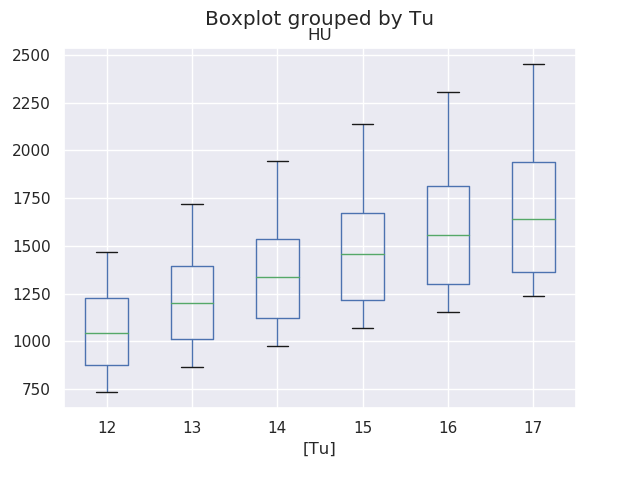

<IPython.core.display.Javascript object>


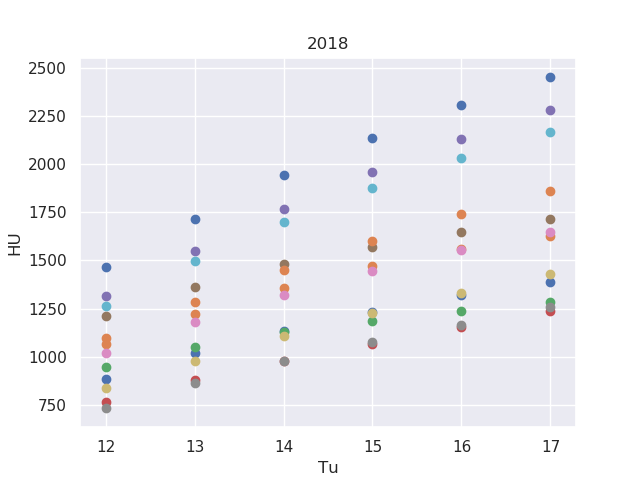

Lokalitet je NS_CE
godina je 2014
    Unnamed: 0 lokalitet  Tu           HU  year
36          36     NS_CE  12   887.367315  2014
37          37     NS_CE  13  1019.071359  2014
38          38     NS_CE  14  1134.196176  2014
39          39     NS_CE  15  1232.388702  2014
40          40     NS_CE  16  1318.521701  2014
41          41     NS_CE  17  1389.561587  2014
Lokalitet je NS_CE
godina je 2015
    Unnamed: 0 lokalitet  Tu           HU  year
48          48     NS_CE  12  1067.275554  2015
49          49     NS_CE  13  1222.047523  2015
50          50     NS_CE  14  1355.445974  2015
51          51     NS_CE  15  1468.524600  2015
52          52     NS_CE  16  1560.043176  2015
53          53     NS_CE  17  1628.729555  2015
Lokalitet je NS_CE
godina je 2016
    Unnamed: 0 lokalitet  Tu           HU  year
42          42     NS_CE  12   947.219655  2016
43          43     NS_CE  13  1050.019676  2016
44          44     NS_CE  14  1126.211295  2016
45          45     NS_CE  15  1184

In [50]:
z=pd.read_csv("GDH_change_ZD_stress_factor_06.csv")
%matplotlib notebook
legenda = []

z[["Tu","HU","lokalitet"]].boxplot(by="Tu")
z[["Tu","HU"]].groupby("Tu").describe().to_csv("descr_ZD_stressfactor06.csv")

ax = plt.figure()
ax.add_subplot()
for lokalitet in mesta:
    for year in range(2014,2019):
        print("Lokalitet je %s"%lokalitet)
        df = z[z.lokalitet==lokalitet]
        df=df[df.year==year]
        print ("godina je %s" %year)
        print (df)
        if not df.empty:
            plt.grid()
            plt.scatter(df.Tu,df.HU)
            plt.title(year)
            plt.xlabel("Tu")
            plt.ylabel("HU")
            legenda.append(str(year)+lokalitet)
            #plt.legend(legenda)


           0       1       2       3       4       5
2014  1159.0  1139.5  1119.5  1096.0  1084.5  1063.5
2015  1510.0  1495.0  1472.0  1448.0  1424.0  1400.0
2016   988.5   978.5   971.5   953.0   934.0   918.5
2017   717.0   705.0   686.0   669.0   659.5   647.0
2018   994.5   980.5   970.5   961.0   954.0   946.5


<IPython.core.display.Javascript object>


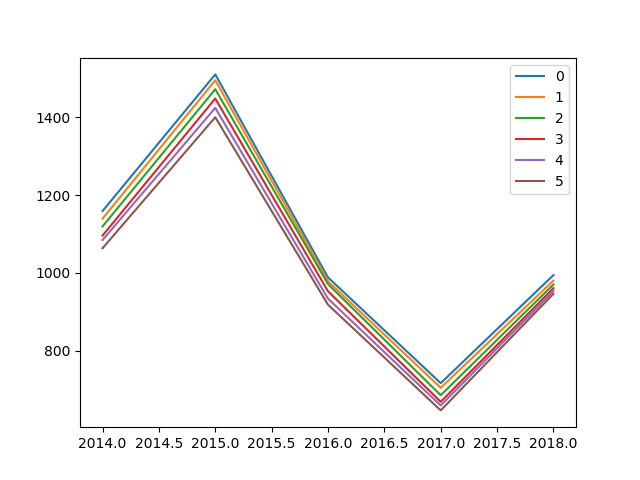

<IPython.core.display.Javascript object>


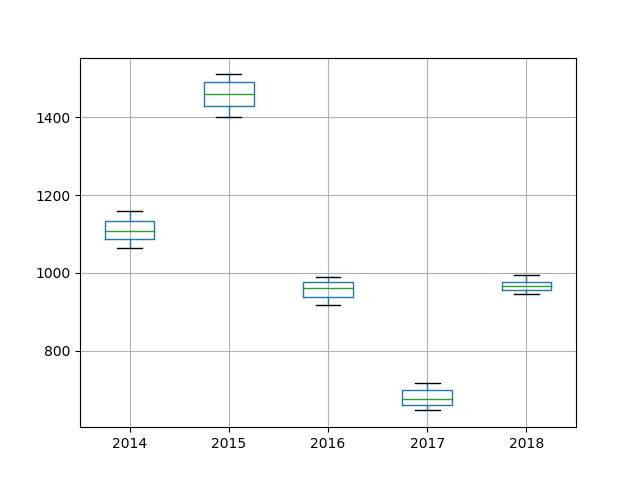

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


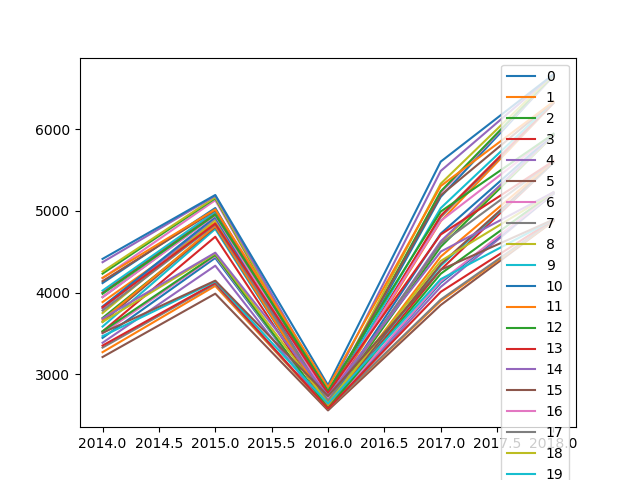

           2014         2015         2016         2017         2018
0   4116.413775  5035.159042  2690.395180  5171.636220  6651.239999
1   3884.050257  4858.230555  2665.039481  4873.225312  6317.205672
2   3689.620798  4794.798155  2624.151141  4560.806272  5923.126133
3   3524.849728  4683.387434  2592.930610  4279.791464  5591.086327
4   3385.791032  4328.971711  2561.724509  4069.669326  5209.027729
5   3211.353497  3986.694238  2558.356197  3847.725272  4874.961622
6   4175.964087  5130.484740  2709.792389  5221.305925  6651.239999
7   3943.600569  4953.556252  2684.436689  4922.895018  6317.205672
8   3749.171110  4890.123852  2643.548349  4610.475977  5923.126133
9   3584.400040  4778.713131  2612.327818  4329.461170  5591.086327
10  3445.341344  4424.297408  2581.121717  4119.339032  5209.027729
11  3270.903809  4082.019935  2577.753406  3897.394977  4874.961622
12  4231.851944  5153.846730  2709.838305  5238.621501  6658.387315
13  3999.488426  4976.918242  2684.482606  4940.

In [174]:
%matplotlib notebook
print (offsets_df.T)
offsets_df.T.plot()
ax= plt.figure()
ax.add_subplot()
offsets_df.boxplot()
ax= plt.figure()
ax.add_subplot()
hu_offsets_df.T.plot()
print (hu_offsets_df)
#hu_offsets_df.boxplot()

<IPython.core.display.Javascript object>


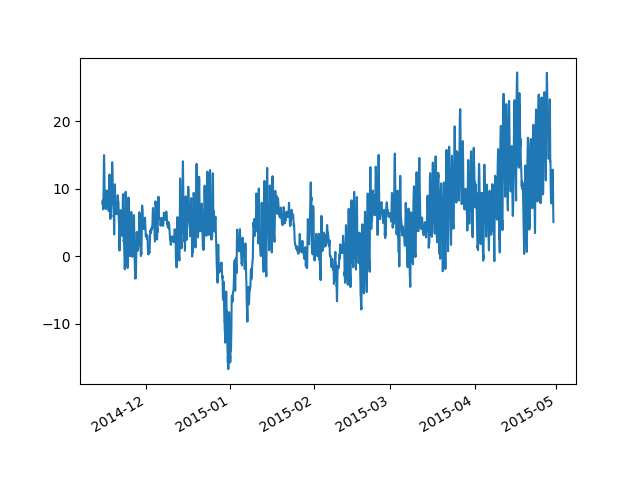

<IPython.core.display.Javascript object>


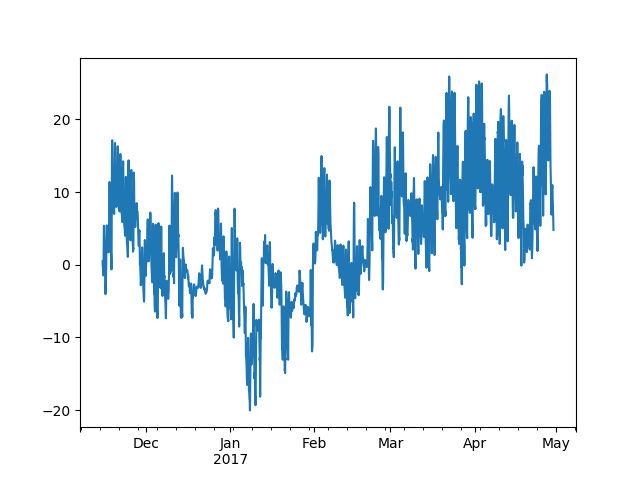

In [100]:
podaci = pd.read_csv("./results/popunjenirezultati/NS_CE_Jabuka_2013-08-02.csv",index_col=0)
    #stavljamo da index bude datum, vazno je da je dayfirst=True, posto su tako sacuvani izgleda
#print (podaci)
podaci.index = pd.to_datetime(podaci.index,dayfirst=True) 

ax= plt.figure()
ax.add_subplot()
year2015=podaci.loc[pd.Timestamp(year=2014,month=11,day=15):pd.Timestamp(year=2015,month=4,day=30)]
year2015["Tavg"].plot()
ax= plt.figure()
ax.add_subplot()
year2017=podaci.loc[pd.Timestamp(year=2016,month=11,day=15):pd.Timestamp(year=2017,month=4,day=30)]
year2017["Tavg"].plot()


    

<IPython.core.display.Javascript object>


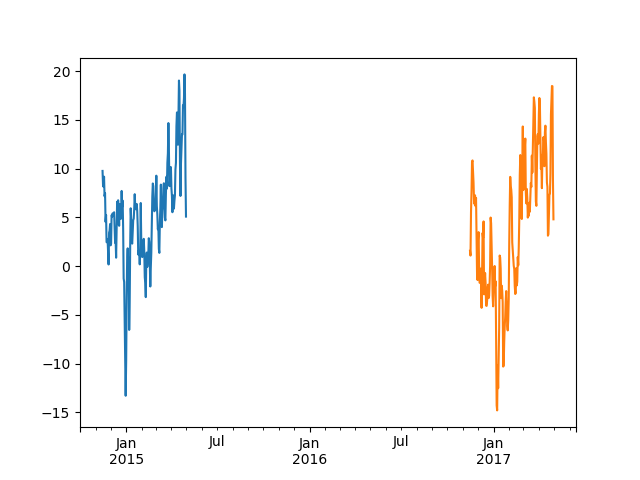

In [102]:
ax= plt.figure()
ax.add_subplot()
daily2015 = year2015.groupby(pd.Grouper(freq='D')).mean()
daily2015["Tavg"].plot()
daily2017 = year2017.groupby(pd.Grouper(freq="D")).mean()
ax= plt.figure()
ax.add_subplot()
daily2017["Tavg"].plot()

<IPython.core.display.Javascript object>


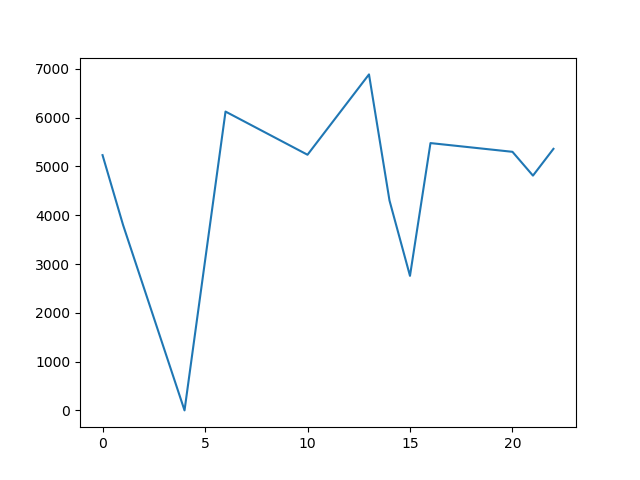

<IPython.core.display.Javascript object>


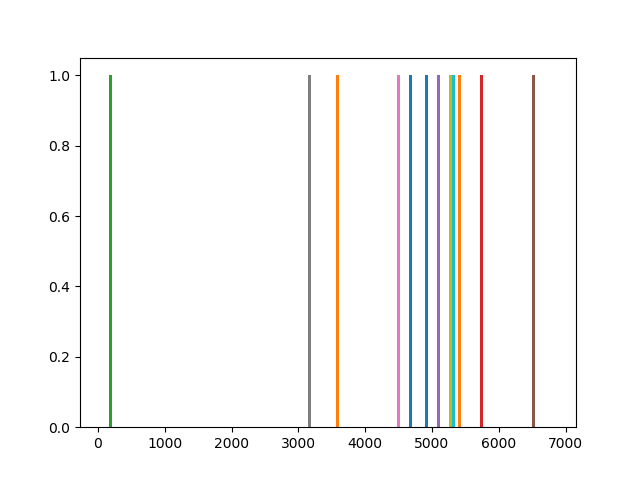

<IPython.core.display.Javascript object>


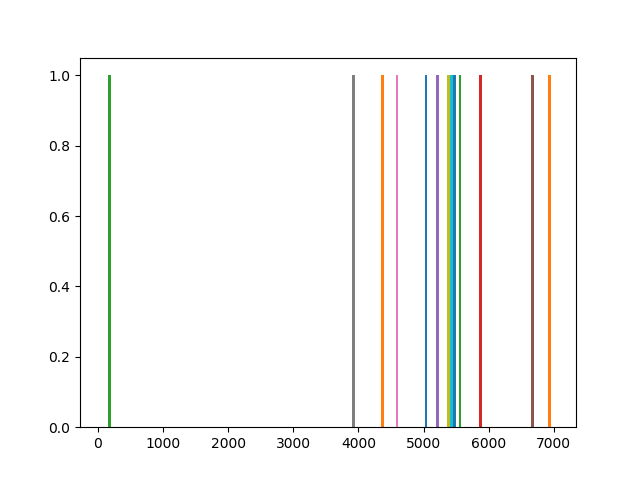

<IPython.core.display.Javascript object>


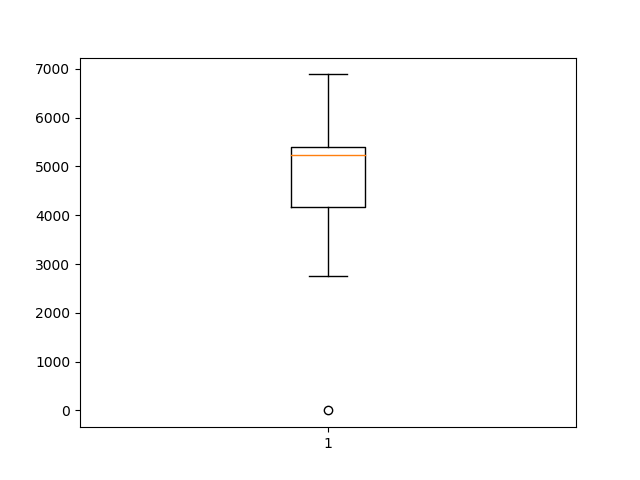

<IPython.core.display.Javascript object>


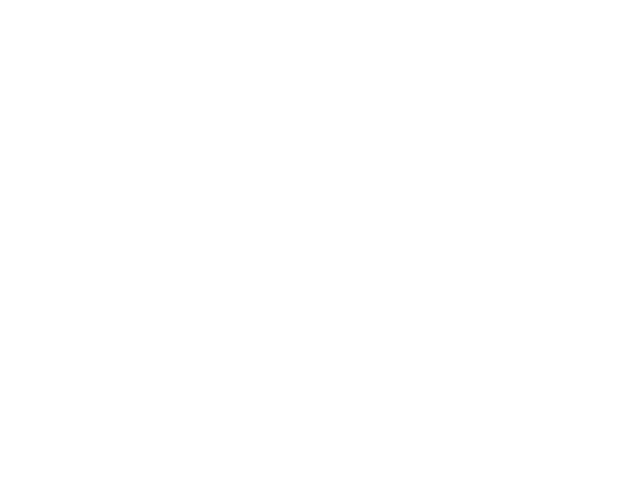

In [156]:
plt.plot(rezultat[rezultat.sorta=="AJ"]["CHU"])
ax= plt.figure()
ax.add_subplot()
plt.plot(rezultat[rezultat.sorta=="AJ"]["HU"])
ax= plt.figure()
ax.add_subplot()
plt.hist(rezultat[rezultat.sorta=="AJ"]["HU"],bins=10)
#plt.hist(rezultat["HU"],bins=3)
ax= plt.figure()
ax.add_subplot()
plt.hist(rezultat[rezultat.sorta=="ZD"]["HU"],bins=10)
rezultat[rezultat.sorta=="AJ"]["HU"]
ax= plt.figure()
ax.add_subplot()

za_box = {"AJ":rezultat[rezultat.sorta=="AJ"]["HU"].tolist(),"AJCHU":rezultat[rezultat.sorta=="AJ"]["CHU"].tolist()}

plt.boxplot(za_box["AJ"])
ax= plt.figure()
ax.add_subplot()
#rezultat.boxplot(by="sorta")

#plt.boxplot(za_box["ZD"])




In [45]:
range?